# Data integration profile example: SDGs

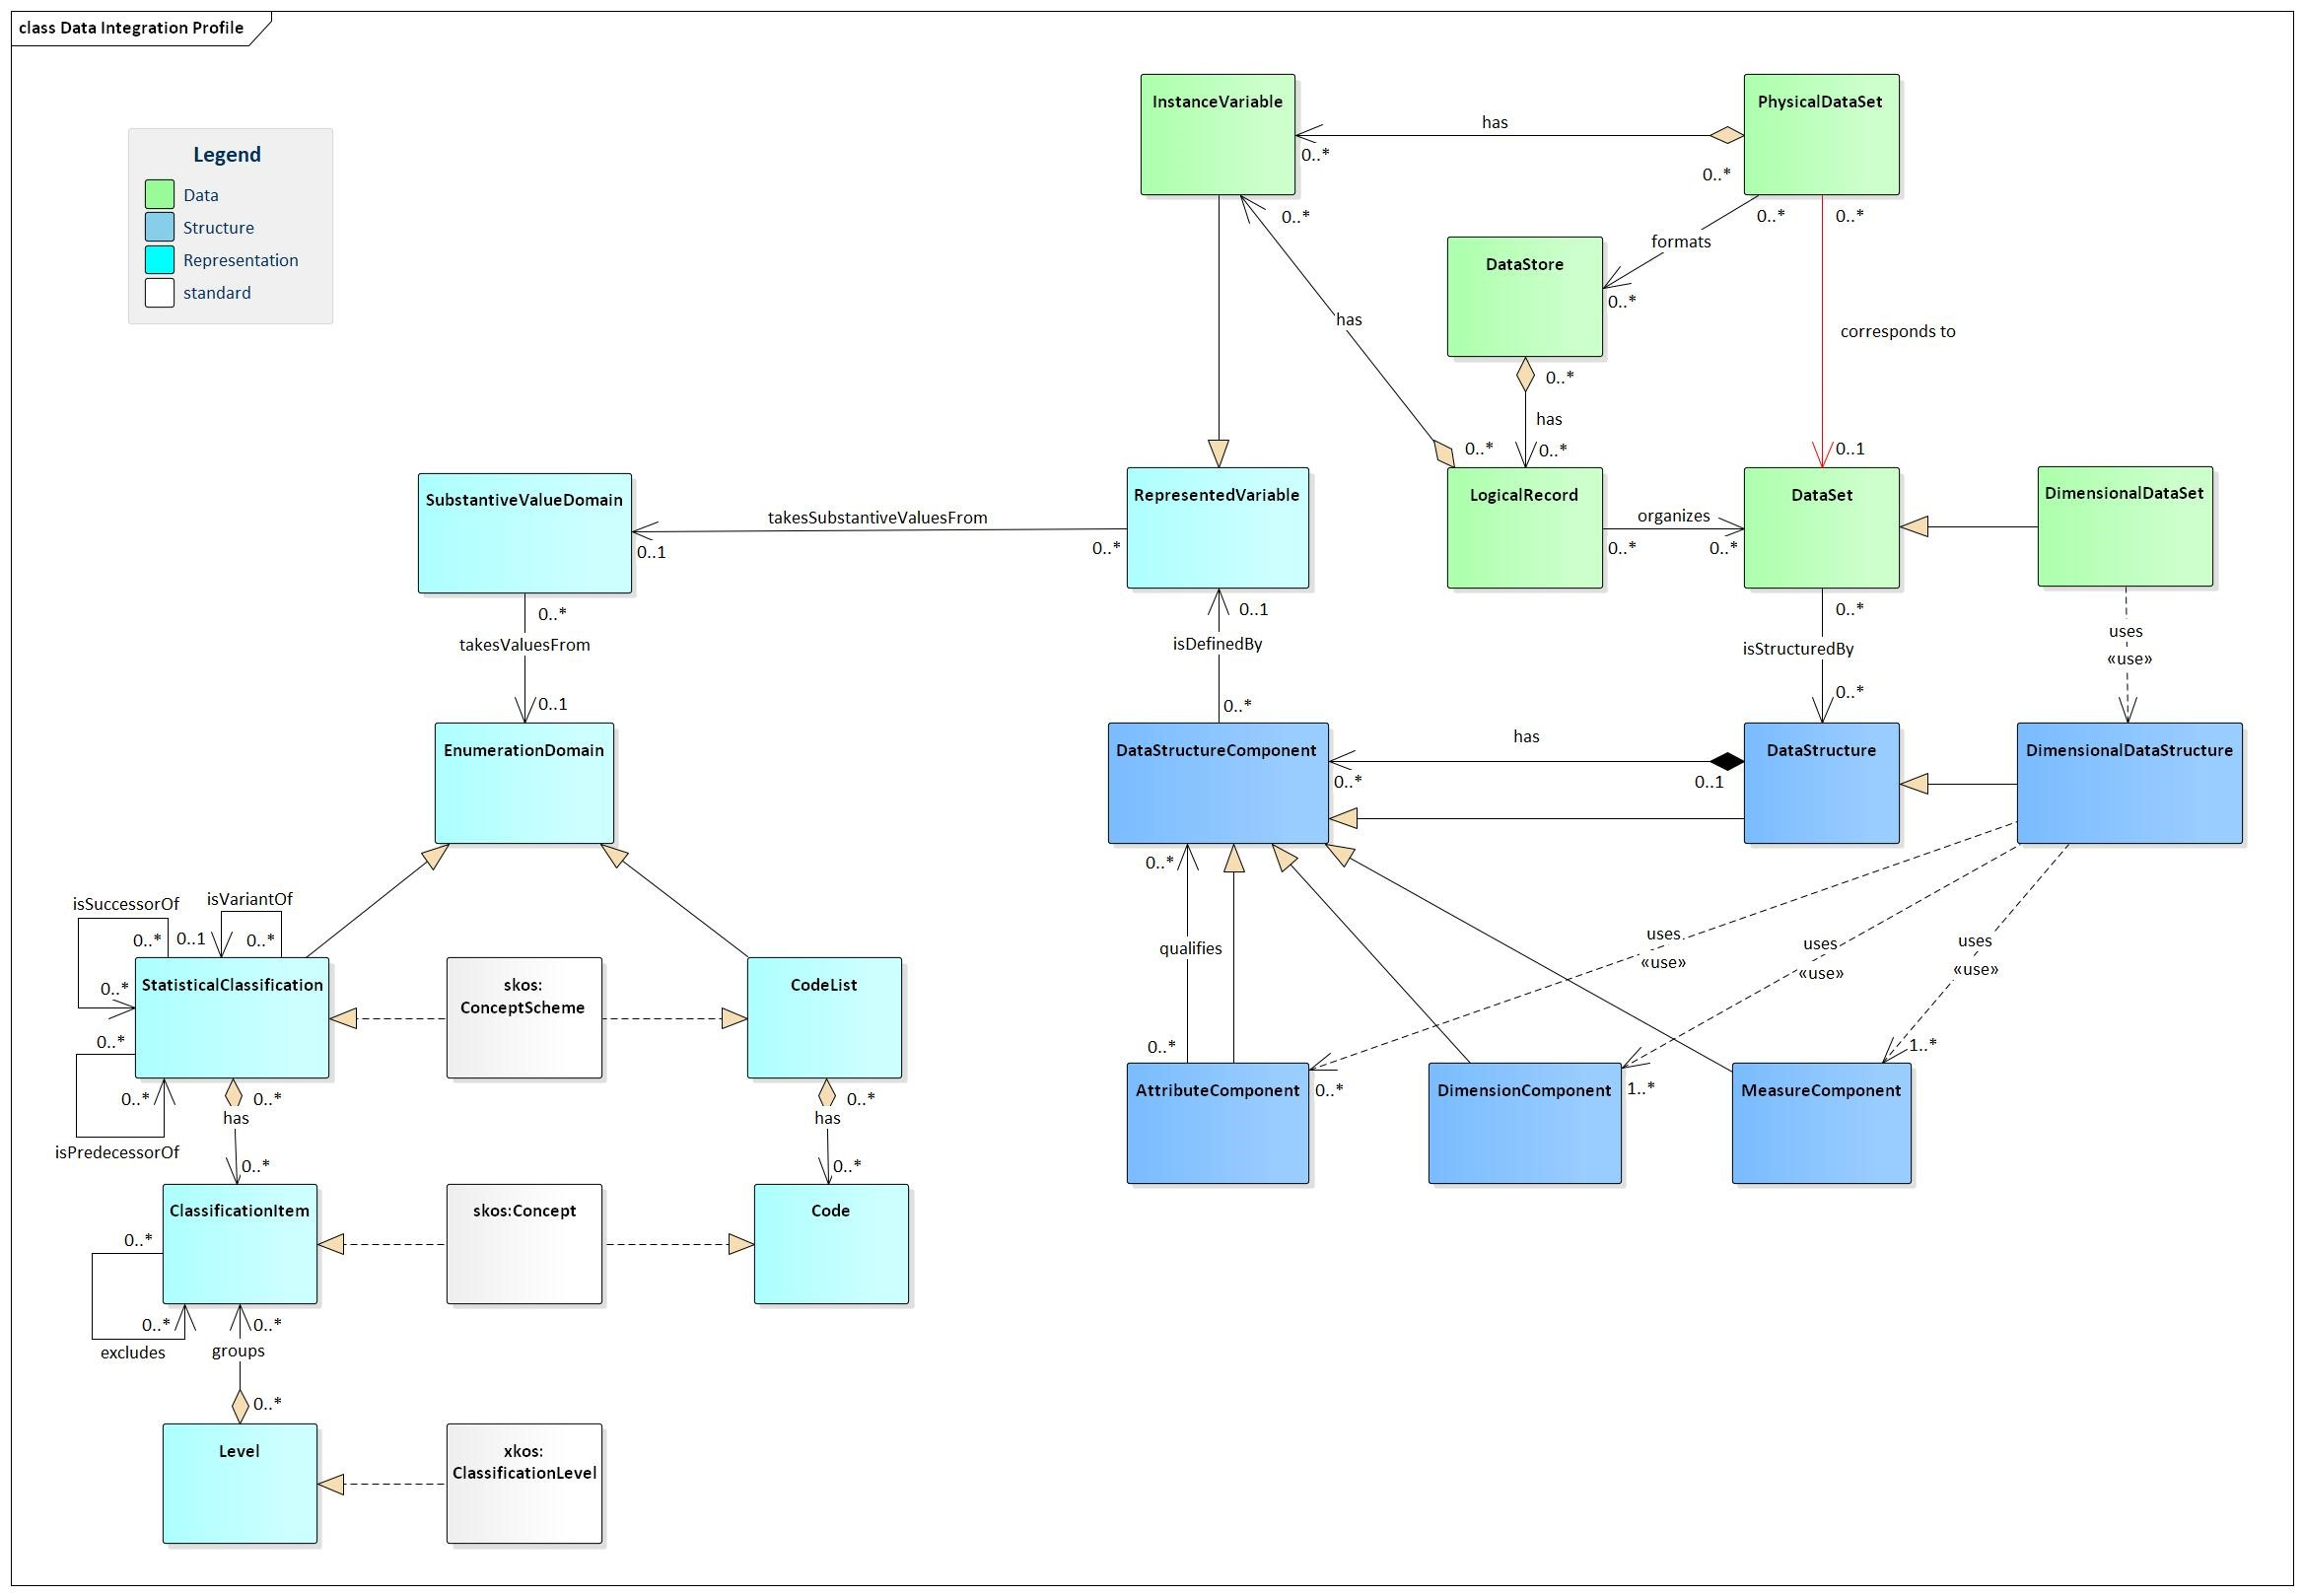

In [1]:
from IPython.display import Image
display(Image(filename='../assets/Data Integration Profile.jpg'))

In [2]:
# Import necessary libraries and modules
import rdflib
from rdflib import Graph, Namespace, URIRef, Literal, BNode
from urllib.parse import urlparse
from rdflib.namespace import NamespaceManager
from rdflib.namespace import RDF, RDFS, SKOS, XSD, OWL
import os

## Read CDI profile

In [3]:
g = Graph()
g.parse('../data/output/cdi_profile1.ttl', format='turtle')
# Define the namespace with the URL
cdi = Namespace("http://ddialliance.org/Specification/DDI-CDI/1.0/RDF/")
g.bind("cdi", cdi)
ilo = Namespace("http://data.un.org/metadata/ilo/")
g.bind("ilo", ilo)

## Read SDMX-DSD from API endpoint

In [4]:
import requests
import xml.etree.ElementTree as ET
import json
from IPython.display import JSON

In [5]:

def strip_namespace(tag):
    """Utility function to remove namespace from the tag."""
    return tag.split('}')[-1]  # Splits on '}' and returns the last part, which is the actual tag name


In [6]:

def xml_to_dict(elem):
    """Convert an XML element to a nested dictionary using actual tag names, stripping namespaces, and simplifying structure."""
    tag = strip_namespace(elem.tag)
    
    # Start with an empty dictionary
    elem_dict = {}
    
    # Include attributes directly in the dictionary
    if elem.attrib:
        elem_dict['attributes'] = {strip_namespace(k): v for k, v in elem.attrib.items()}
    
    # Include text content if it exists and is more than just whitespace
    text = elem.text.strip() if elem.text and elem.text.strip() else None
    if text:
        elem_dict['text'] = text

    # Recursively handle child elements
    children = {}
    for child in elem:
        child_dict = xml_to_dict(child)
        child_tag = strip_namespace(child.tag)
        if child_tag in children:
            # If the tag is already in the dictionary, append to list or convert to list
            if not isinstance(children[child_tag], list):
                children[child_tag] = [children[child_tag]]
            children[child_tag].append(child_dict[child_tag])
        else:
            children[child_tag] = child_dict[child_tag]
    
    # If there are children, add them
    if children:
        if 'attributes' in elem_dict or 'text' in elem_dict:
            elem_dict.update(children)
        else:
            elem_dict = children

    return {tag: elem_dict}


In [7]:

def fetch_and_convert_xml(url):
    """Fetch XML from the URL and convert it to a nested dictionary."""
    response = requests.get(url)
    if response.status_code == 200:
        # Parse XML content
        root = ET.fromstring(response.content)
        # Convert XML to nested dictionary
        xml_dict = xml_to_dict(root)
        return xml_dict
    else:
        return f"Failed to fetch data. Status code: {response.status_code}"


In [8]:
# Specify the API endpoint
api_url = 'https://sdmx.ilo.org/rest/datastructure/ILO/UNE_TUNE_SEX_AGE_NB?references=descendants'

In [9]:
dsd = fetch_and_convert_xml(api_url)
JSON(dsd)

<IPython.core.display.JSON object>

In [10]:
code_lists = dsd['Structure']['Structures']['Codelists']['Codelist']
JSON(code_lists)

<IPython.core.display.JSON object>

In [11]:
concept_schemes = dsd['Structure']['Structures']['Concepts']['ConceptScheme']
JSON(concept_schemes)

<IPython.core.display.JSON object>

In [12]:
def find_codelists(code_lists, code_list_id):
    # Iterate through each element in the list
    for cl in code_lists:
        # Check if the element has 'attributes' and 'id' matches the target_id
        if 'attributes' in cl and cl['attributes'].get('id') == code_list_id:
            return cl
    return None  # Return None if no matching element is found

In [13]:
JSON(find_codelists(code_lists, 'CL_UNIT_MULT'))

<IPython.core.display.JSON object>

In [14]:
def find_concepts(concept_schemes, concept_scheme_id):
    # Check if the input is a list and iterate through it
    if isinstance(concept_schemes, list):
        for cs in concept_schemes:
            # Recursive call to search within each element
            result = find_concepts(cs, concept_scheme_id)
            if result:
                return result['Concept']

    # Check if the input is a dictionary and look for 'attributes' and then 'id'
    elif isinstance(concept_schemes, dict):
        # Check if 'attributes' exists and has 'id' matching target_id
        if 'attributes' in concept_schemes and concept_schemes['attributes'].get('id') == concept_scheme_id:
            return concept_schemes
        
        # Otherwise, search recursively through each value in the dictionary
        for key, value in concept_schemes.items():
            result = find_concepts(value, concept_scheme_id)
            if result:
                return result['Concept']

    # Return None if no match is found
    return None

In [15]:
JSON(find_concepts(concept_schemes, 'CS_ILOSTAT'))

<IPython.core.display.JSON object>

## Add DimensionalDataSet

In [16]:
ds_components = dsd['Structure']['Structures']['DataStructures']['DataStructure']['DataStructureComponents']

In [17]:
DimensionComponents =  []

for d in ds_components['DimensionList']['Dimension']: 
    x = d['ConceptIdentity']['Ref']['attributes']

    # Safely navigate through the nested dictionaries
    enumeration = (d.get('LocalRepresentation', {})
                     .get('Enumeration', {})
                     .get('Ref', {})
                     .get('attributes'))

    if enumeration is not None:
        x['LocalRepresentation'] = {'type': 'enumeration', **enumeration}
    else:
        print("LocalRepresentation does not exist")

    concept_id = x['id']
    concept_scheme = x['maintainableParentID']

    concepts = find_concepts(concept_schemes, concept_scheme)
    for c in concepts:
        if c['attributes']['id'] == concept_id:
            x['name'] = []
            for cn in c['Name']:
                x['name'].append({'text': cn['text'], 'lang': cn['attributes']['lang']})

    DimensionComponents.append(x)
display(JSON(DimensionComponents))

<IPython.core.display.JSON object>

In [18]:
td = ds_components['DimensionList']['TimeDimension']
TimeDimension = td['ConceptIdentity']['Ref']['attributes']

representation = (td.get('LocalRepresentation', {})
                     .get('TextFormat', {})
                     .get('attributes'))
if representation is not None:
    TimeDimension['LocalRepresentation'] = {'type': 'textFormat', **representation}
else:
    print("LocalRepresentation does not exist")



concept_id = TimeDimension['id']
concept_scheme = TimeDimension['maintainableParentID']

concepts = find_concepts(concept_schemes, concept_scheme)
for c in concepts:
    if c['attributes']['id'] == concept_id:
        TimeDimension['name'] = []
        for cn in c['Name']:
            TimeDimension['name'].append({'text': cn['text'], 'lang': cn['attributes']['lang']})

display(JSON(TimeDimension))

<IPython.core.display.JSON object>

In [19]:
AttributeComponents =  []

for a in ds_components['AttributeList']['Attribute']: 
    x = a['ConceptIdentity']['Ref']['attributes']

    # Safely navigate through the nested dictionaries
    enumeration = (a.get('LocalRepresentation', {})
                     .get('Enumeration', {})
                     .get('Ref', {})
                     .get('attributes'))

    if enumeration is not None:
        x['LocalRepresentation'] = {'type': 'enumeration', **enumeration}
    else:
        print("LocalRepresentation does not exist")

    

    concept_id = x['id']
    concept_scheme = x['maintainableParentID']

    concepts = find_concepts(concept_schemes, concept_scheme)
    for c in concepts:
        if c['attributes']['id'] == concept_id:
            x['name'] = []
            for cn in c['Name']:
                x['name'].append({'text': cn['text'], 'lang': cn['attributes']['lang']})
                

    AttributeComponents.append(x)
display(JSON(AttributeComponents))

LocalRepresentation does not exist
LocalRepresentation does not exist
LocalRepresentation does not exist
LocalRepresentation does not exist
LocalRepresentation does not exist
LocalRepresentation does not exist


<IPython.core.display.JSON object>

In [20]:

MeasureComponents =  []

m = ds_components['MeasureList']['PrimaryMeasure']

x = m['ConceptIdentity']['Ref']['attributes']
representation = (x.get('LocalRepresentation', {})
                     .get('TextFormat', {})
                     .get('attributes'))

if representation is not None:
    x['LocalRepresentation'] = {'type': 'textFormat', **representation}
else:
    print("LocalRepresentation does not exist")



concept_id = x['id']
concept_scheme = x['maintainableParentID']

concepts = find_concepts(concept_schemes, concept_scheme)
for c in concepts:
    if c['attributes']['id'] == concept_id:
        x['name'] = []
        for cn in c['Name']:
            x['name'].append({'text': cn['text'], 'lang': cn['attributes']['lang']})

MeasureComponents.append(x)
display(JSON(MeasureComponents))

LocalRepresentation does not exist


<IPython.core.display.JSON object>

In [21]:
x = dsd['Structure']['Structures']['DataStructures']['DataStructure']

DimensionalDataStructure =  x['attributes']

DimensionalDataStructure['name'] = [
    {'text': x['Name'][0]['text'], 'lang': x['Name'][0]['attributes']['lang']},
    {'text': x['Name'][1]['text'], 'lang': x['Name'][1]['attributes']['lang']},
    {'text': x['Name'][2]['text'], 'lang': x['Name'][2]['attributes']['lang']}]

DimensionalDataStructure['description'] = [
    {'text': x['Description'][0]['text'], 'lang': x['Name'][0]['attributes']['lang']},
    {'text': x['Description'][1]['text'], 'lang': x['Name'][1]['attributes']['lang']},
    {'text': x['Description'][2]['text'], 'lang': x['Name'][2]['attributes']['lang']}]

JSON(DimensionalDataStructure)

<IPython.core.display.JSON object>

# Populate profile with individuals

### 1. DimensionalDataSet

In [22]:
g.add((ilo[DimensionalDataStructure['id']], RDF.type, cdi.DimensionalDataSet))
for n in DimensionalDataStructure['name']:
    g.add((ilo[DimensionalDataStructure['id']], 
           cdi['DimensionalDataSet-name'], 
           Literal(n['text'], lang = n['lang'])))


### 2. DimensionalDataStructure

In [23]:
g.add((ilo[DimensionalDataStructure['id']+'/DSD'], 
       RDF.type, 
       cdi.DimensionalDataStructure))


<Graph identifier=N909119ed9aba45fe8399814d04a58940 (<class 'rdflib.graph.Graph'>)>

### 3. DataStructureComponents

In [24]:
JSON(DimensionComponents)

<IPython.core.display.JSON object>

In [25]:
for dc in DimensionComponents:
    
    g.add((ilo[f"DimensionComponent/{dc['id']}"], 
           RDF.type, 
           cdi.DimensionComponent))
    
    if dc['id'] == 'REF_AREA':
        g.add((ilo[f"DimensionComponent/{dc['id']}"], 
               cdi['DataStructureComponent-specialization'], 
               cdi['GeoRole']))
        
    g.add((ilo[DimensionalDataStructure['id']+'/DSD'], 
           cdi.hasComponent, 
           ilo[f"DimensionComponent/{dc['id']}"]))

    #----- Variable Cascade

    g.add((ilo[f"InstanceVairable/{dc['id']}"], 
           RDF.type, 
           cdi.InstanceVariable))

    g.add((ilo[f"RepresentedVairable/{dc['id']}"], 
           RDF.type, 
           cdi.RepresentedVariable))
    
    for n in dc['name']:
        g.add((ilo[f"InstanceVairable/{dc['id']}"], 
               RDFS['label'], 
               Literal(n['text'], lang = n['lang'])))

        g.add((ilo[f"RepresentedVairable/{dc['id']}"], 
               RDFS['label'], 
               Literal(n['text'], lang = n['lang'])))

    g.add((ilo[f"InstanceVairable/{dc['id']}"], 
           cdi['InstanceVariable_isBasedOn_RepresentedVariable'], 
           ilo[f"RepresentedVairable/{dc['id']}"]))
    
    g.add((ilo[f"DimensionComponent/{dc['id']}"], 
           cdi.DataStructureComponent_isDefinedBy_RepresentedVariable, 
           ilo[f"RepresentedVairable/{dc['id']}"]))


    #----- Add Code lists as instances of skos:ConceptScheme
    print(dc['LocalRepresentation']['type'])
    if dc['LocalRepresentation']['type'] == 'enumeration':
        
        code_list_id = dc['LocalRepresentation']['id']
        code_list = find_codelists(code_lists, code_list_id)
        
        g.add((
            ilo[f"ConceptScheme/{code_list_id}"], 
            RDF.type,
            SKOS.ConceptScheme
        ))
        
        g.add((
            ilo[f"SubstantiveValueDomain/{code_list_id}"], 
            RDF.type,
            cdi.SubstantiveValueDomain
        ))
        
        g.add((
            ilo[f"SubstantiveValueDomain/{code_list_id}"], 
            cdi.SubstantiveValueDomain_takesValuesFrom_EnumerationDomain,
            ilo[f"ConceptScheme/{code_list_id}"]
        ))


        g.add((ilo[f"RepresentedVairable/{dc['id']}"], 
               cdi.RepresentedVariable_takesSubstantiveValuesFrom_SubstantiveValueDomain, 
               ilo[f"SubstantiveValueDomain/{code_list_id}"]))

        #--------ADD INVIDUAL CODES

        for c in code_list['Code']:
            
            g.add((
                ilo[f"Concept/{code_list_id}/{c['attributes']['id']}"], 
                RDF.type,
                SKOS.Concept,
            ))
            
            g.add((
                ilo[f"Concept/{code_list_id}/{c['attributes']['id']}"], 
                SKOS.inScheme,
                ilo[f"SubstantiveValueDomain/{code_list_id}"],
            ))


            for cn in c['Name']:
                g.add((ilo[f"Concept/{code_list_id}/{c['attributes']['id']}"], 
                   RDFS['label'], 
                   Literal(cn['text'], lang = cn['attributes']['lang'])))







#----------------------------------------------
    
g.add((ilo[f"DimensionComponent/{TimeDimension['id']}"], 
       RDF.type, 
       cdi.DimensionComponent))

g.add((ilo[f"DimensionComponent/{TimeDimension['id']}"], 
       cdi['DataStructureComponent-specialization'], 
       cdi['TimeRole']))

g.add((ilo[DimensionalDataStructure['id']+'/DSD'], 
       cdi.hasComponent, 
       ilo[f"DimensionComponent/{TimeDimension['id']}"]))


#----- Variable Cascade

g.add((ilo[f"InstanceVairable/{TimeDimension['id']}"], 
       RDF.type, 
       cdi.InstanceVariable))

g.add((ilo[f"RepresentedVairable/{TimeDimension['id']}"], 
       RDF.type, 
       cdi.RepresentedVariable))

for n in TimeDimension['name']:
    g.add((ilo[f"InstanceVairable/{TimeDimension['id']}"], 
           RDFS['label'], 
           Literal(n['text'], lang = n['lang'])))
    
    g.add((ilo[f"RepresentedVairable/{TimeDimension['id']}"], 
           RDFS['label'], 
           Literal(n['text'], lang = n['lang'])))


g.add((ilo[f"InstanceVairable/{TimeDimension['id']}"], 
       cdi['InstanceVariable_isBasedOn_RepresentedVariable'], 
       ilo[f"RepresentedVairable/{TimeDimension['id']}"]))

g.add((ilo[f"DimensionComponent/{TimeDimension['id']}"], 
       cdi.DataStructureComponent_isDefinedBy_RepresentedVariable, 
       ilo[f"RepresentedVairable/{TimeDimension['id']}"]))

enumeration
enumeration
enumeration
enumeration
enumeration


<Graph identifier=N909119ed9aba45fe8399814d04a58940 (<class 'rdflib.graph.Graph'>)>

In [26]:
for ac in AttributeComponents:
    g.add((ilo[f"AttributeComponent/{ac['id']}"], 
           RDF.type, 
           cdi.AttributeComponent))
    
    # g.add((ilo[ac['id']], cdi['AttributeComponent_qualifies_DataStructureComponent'], <???>))  # <<-----Check
    
    g.add((ilo[DimensionalDataStructure['id']+'/DSD'], 
           cdi.hasComponent, 
           ilo[f"AttributeComponent/{ac['id']}"]))

    
    #----- Variable Cascade

    g.add((ilo[f"InstanceVairable/{ac['id']}"], 
           RDF.type, 
           cdi.InstanceVariable))

    g.add((ilo[f"RepresentedVairable/{ac['id']}"], 
           RDF.type, 
           cdi.RepresentedVariable))
    
    for n in ac['name']:
        g.add((ilo[f"InstanceVairable/{ac['id']}"], 
               RDFS['label'], 
               Literal(n['text'], lang = n['lang'])))

        g.add((ilo[f"RepresentedVairable/{ac['id']}"], 
               RDFS['label'], 
               Literal(n['text'], lang = n['lang'])))

    g.add((ilo[f"InstanceVairable/{ac['id']}"], 
           cdi['InstanceVariable_isBasedOn_RepresentedVariable'], 
           ilo[f"RepresentedVairable/{ac['id']}"]))
    
    g.add((ilo[f"AttributeComponent/{ac['id']}"], 
           cdi.DataStructureComponent_isDefinedBy_RepresentedVariable, 
           ilo[f"RepresentedVairable/{ac['id']}"]))

    

    #----- Add Code lists as instances of skos:ConceptScheme

    if 'LocalRepresentation' in ac and ac['LocalRepresentation']['type'] == 'enumeration':
        code_list_id = ac['LocalRepresentation']['id']

        code_list = find_codelists(code_lists, code_list_id)
        
        g.add((
            ilo[f"ConceptScheme/{code_list_id}"], 
            RDF.type,
            SKOS.ConceptScheme
        ))
        
        g.add((
            ilo[f"SubstantiveValueDomain/{code_list_id}"], 
            RDF.type,
            cdi.SubstantiveValueDomain
        ))
        
        g.add((
            ilo[f"SubstantiveValueDomain/{code_list_id}"], 
            cdi.SubstantiveValueDomain_takesValuesFrom_EnumerationDomain,
            ilo[f"ConceptScheme/{code_list_id}"]
        ))

        g.add((ilo[f"RepresentedVairable/{ac['id']}"], 
               cdi.RepresentedVariable_takesSubstantiveValuesFrom_SubstantiveValueDomain, 
               ilo[f"SubstantiveValueDomain/{code_list_id}"]))


        #--------ADD INVIDUAL CODES

        for c in code_list['Code']:
            
            g.add((
                ilo[f"Concept/{code_list_id}/{c['attributes']['id']}"], 
                RDF.type,
                SKOS.Concept,
            ))
            
            g.add((
                ilo[f"Concept/{code_list_id}/{c['attributes']['id']}"], 
                SKOS.inScheme,
                ilo[f"SubstantiveValueDomain/{code_list_id}"],
            ))

            for cn in c['Name']:
                g.add((ilo[f"Concept/{code_list_id}/{c['attributes']['id']}"], 
                   RDFS['label'], 
                   Literal(n['text'], lang = cn['attributes']['lang'])))

In [27]:
for mc in MeasureComponents:
    
    g.add((ilo[f"MeasureComponent/{mc['id']}"], 
           RDF.type, 
           cdi.MeasureComponent))
    
    g.add((ilo[DimensionalDataStructure['id']+'/DSD'], 
           cdi.hasComponent, 
           ilo[f"MeasureComponent/{mc['id']}"]))

    
    #----- Variable Cascade

    g.add((ilo[f"InstanceVairable/{mc['id']}"], 
           RDF.type, 
           cdi.InstanceVariable))

    g.add((ilo[f"RepresentedVairable/{mc['id']}"], 
           RDF.type, 
           cdi.RepresentedVariable))
    
    for n in mc['name']:
        g.add((ilo[f"InstanceVairable/{mc['id']}"], 
               RDFS['label'], 
               Literal(n['text'], lang = n['lang'])))

        g.add((ilo[f"RepresentedVairable/{mc['id']}"], 
               RDFS['label'], 
               Literal(n['text'], lang = n['lang'])))

    g.add((ilo[f"InstanceVairable/{mc['id']}"], 
           cdi['InstanceVariable_isBasedOn_RepresentedVariable'], 
           ilo[f"RepresentedVairable/{mc['id']}"]))
    
    g.add((ilo[f"MeasureComponent/{mc['id']}"], 
           cdi.DataStructureComponent_isDefinedBy_RepresentedVariable, 
           ilo[f"RepresentedVairable/{mc['id']}"]))

    

## Save cdif profile

In [28]:
g.serialize(destination=f"../data/output/cdi_profile_{DimensionalDataStructure['id']}.ttl", format='turtle')

<Graph identifier=N909119ed9aba45fe8399814d04a58940 (<class 'rdflib.graph.Graph'>)>

In [29]:
g.serialize(destination=f"../data/output/cdi_profile_{DimensionalDataStructure['id']}.jsonld", format='json-ld')



<Graph identifier=N909119ed9aba45fe8399814d04a58940 (<class 'rdflib.graph.Graph'>)>